<a href="https://colab.research.google.com/github/gcfer/reinforcement-learning/blob/main/RL_REINFORCE_TF2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: REINFORCE (Policy Gradient Algorithm)

## Overview

In this notebook, we'll cover policy gradient algorithms, and we'll implement `REINFORCE`, the archetypal policy gradient algorithm. We'll test it by solving the cartpole problem in the Open AI gym. 

In [ ]:
import numpy as np
import pandas as pd
import datetime

# Import tensorflow
#!pip install tensorflow-gpu==1.14.0 > /dev/null 2>&1
import tensorflow as tf
import tensorflow.keras as K
print(tf.__version__)

# Check that tf sees the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

# Import libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # this makes plot in high res

2.4.0
/device:GPU:0


Since we are in a remote notebook, we cannot display the progress of the environment in real time. Instead, we store the renderings and show a video at the end of the episode (refer to [this](https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/) guide in case you need it). The only advice that I can give is to import `gym` _after_ the update below.

In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
# Maybe
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [ ]:
# Open AI gym
import gym 
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import random
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(2880, 1800))
display.start()

The function below is needed to display the video. I slightly modified it from the original one (that you can in the guide I linked above) to avoid the infinite repetition loop of the video.

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## OpenAI Gym Cartpole

The Cartpole problem is a discrete control problem where we try to keep the pole vertical by moving the cart below it. 

Upon loading the environment, we launch a simulation where the agent chooses at random from the action sample space the next action. Finally, we show the video of the result. What happens is that the problem is considered unsolved (= game over) if the angle between pole and the line orthogonal to the cart axis is larger than a threshold. The parameter `done` specifies when the experiment is over.

In [ ]:
# Load the environment and start
env = wrap_env(gym.make("CartPole-v0"))

In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
    if done: 
      break;
            
env.close()

In [ ]:
show_video()

To better understand the inputs and outputs of the environment, let consider the action space and the observation space.

The action space is of type `Discrete(n)` where `n` is the number of actions. This is equivalent to the discrete set $\{ 0, 1, 2, \dotsc, n-1 \}$.

In [ ]:
env.action_space

Discrete(2)

The observation space is of type `Box(n)`, which means that it is the Cartesian product of `n` intervals.

In [ ]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [ ]:
[env.observation_space.low, env.observation_space.high]

[array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32)]

When we make a step in the environment, the feedback that we get includes the observation:

In [ ]:
#env = gym.make('CartPole-v0')
# env = Monitor(env, './video', force=True)
env.reset()

obs, r, done, _ = env.step(0)
print(obs)

[-0.0248302  -0.19857408  0.00899464  0.29775695]


## Policy Gradient Algorithms

Policy gradient algorithms seek to learn the policy via gradient descent, as the name suggests. They differ from value-based algorithms that instead learn the Q-function and derive the policy from there, and thus indirectly. 

To be more precise, a policy gradient algorithm seeks to learn the probability of each action given the current state, i.e., the policy $\pi(s,a)$. Then we take the action by randomly sampling $\pi(s,a)$.

In order to fit $\pi(s,a)$, we need to define an objective function. Since the neural network can approximate “any” function, we shall keep the neural network find the parameters $\theta$ of the policy $\pi_\theta$ that maximizes the future expected discounted reward:

$$ \theta^* = \arg\max_\theta \mathbf{E}\!\left[\sum_{t=0}^T\gamma^t r(s_t,a_t)\right] $$

where the expectation is over trajectories $\tau=(s_0, a_0, r_0, s_1, a_1, r_1, \cdots, r_{T})$, $r_t:=r(s_t,a_t)$ is the reward that we get when we take action $a_t$ in state $s_t$, and $T$ is the length of the episode. 

As a shorthand, define the future discounted reward
$$ R(\tau) =\sum_{t=0}^T\gamma^t r(s_t,a_t). $$
The expected value of $R$ is just the value function. To be extremely clear, it is very important to recognize that $R$ depends on the trajectory, but it does not depend on the weights of the policy. In fact, two different policies that suggest the same actions would get to the same value of $R$. In other words, $R$ depends on the actions, not on why or how those actions have been taken. This is very important in deriving the gradient with respect to $\theta$ below. 

The trajectory follows a Markov decision process, i.e.

$$ p_\theta(\tau) = \prod_{t=0}^T p(s_{t}|a_{t-1},s_{t-1})\pi_\theta(a_t|s_t) $$
with the convention that $p(s_0|a_{-1}, s_{-1})=p_0(s_0)$ where $p_0$ is the density of the distribution of initial states. Putting all together:

$$ \theta^* = \arg\max_\theta \int \prod_{t=0}^T ds_t\, da_t \, \pi_\theta(a_t|s_t) p(s_{t}|a_{t-1}, s_{t-1}) \, R(\tau). $$

To find the maximum, we compute the gradient with respect to $\theta$ of the objective function above:

\begin{align} \nabla_\theta \mathbf{E}[R(\tau)] 
& = \int d\tau \nabla p_\theta(\tau) R(\tau) \\ & =  \int d\tau p_\theta(\tau) \nabla_\theta\!\log p_\theta(\tau) R(\tau) \\
& = \mathbf{E}[\nabla_\theta\!\log p_\theta(\tau) R(\tau)] \\
& = \mathbf{E}\!\left[\sum_{t=0}^T \nabla_\theta\!\log \pi_\theta(a_t|s_t) R(\tau)\right]. 
\end{align}
Notice that $R(\tau)$ multiplies the entire sum, that is,

$$ \nabla_\theta \mathbf{E}[R(\tau)]  = \mathbf{E}\!\left[R(\tau)\sum_{t=0}^T \nabla_\theta\!\log \pi_\theta(a_t|s_t) \right]. $$

By integrating back in $\theta$, we get that an equivalent objective function to maximize is given by the expression above without the gradient, i.e.
$$ \theta^* = \arg\max_\theta \mathbf{E}\!\left[R(\tau)\sum_{t=0}^T \log \pi_\theta(a_t|s_t) \right]. $$

From a theoretical perspective, this is pretty much what a policy gradient algorithm does. 

From a practical perspective, the integral is evaluated via the Monte Carlo method over several trajectories (episodes). That is, we sample a trajectory, optimize over it, and repeat this process several times. 

The way it is implemented below is the following. We sample a trajectory with the previously available $\pi_\theta$. We save in memory all steps, actions, and rewards. We form the artificial distribution $\tilde{\pi}_t(a, a_t)=\delta_{a,a_t}$ where $\delta$ is the Kronecker delta. This is our “target distribution” since we expect, at convergence, that there is always a best action to take and that $\pi_\theta$ suggests such best action. To compare $\pi_\theta$ and $\tilde{\pi}_t$ we use the <font color='green'>categorical crossentropy</font>. The loss function is given by

\begin{align} L(\tau) & = R(\tau)\sum_{t=0}^T h(\tilde{\pi}_t, \pi_\theta) \\ & = R(\tau)\sum_{t=0}^T  {\color{green}{\sum_{a\in\mathcal{A}} -\tilde{\pi}_t(a) \log (\pi_\theta(a))}} \\
& = -R(\tau)\sum_{t=0}^T  \log (\pi_\theta(a_t)).
\end{align}
Minimizing $L(\tau)$ is equivalent to the maximization problem that we illustrated above. 

To speed up the learning process, we provide all steps at once to the network, and compute a slightly different loss. Firstly, let us simplify the loss above via

$$ L(\tau) \approx -R(\tau) \log(\pi_\theta(a_0)).$$

Secondly, define the discounted future reward from $t'$ to $T$,

$$R(\tau_{t'}) := R(s_{t'}, a_{t'}, r_{t'}, \cdots, s_{T}, a_{T}, r_{T}),$$

for all $t'\in[0:T]$. Finally, we define a cumulative loss by summing up the loss at each step in the episode:
\begin{align} L(\tau) & \approx - \sum_{t=0}^T R(\tau_{t}) \log (\pi_\theta(a_t)).
\end{align}

In [ ]:
# REINFORCE
class REINFORCE:
  
  def __init__(self, state_size, action_size, gamma=None, max_steps=None):
    # max_steps is the maximum number of batches [s, a, r, s_] or epochs remembered
    
    # Parameters
    self.state_size = state_size
    self.action_size = action_size
    
    self.memory = list()
    if gamma is None: 
      self.gamma = 0.99
    else: 
      self.gamma = gamma
    
    if max_steps is None:
      self.max_steps = 200 
    else:
      self.max_steps = max_steps

    self.lr = 0.005       # learning rates

    # actor network
    self.actor = self.build_actor()

  def remember(self, s, a, r, s_, done):
    self.memory.append([s, a, r, s_, done])
    if len(self.memory) > self.max_steps: # if too long
      self.memory.pop(0) # forget the oldest
  
  def forget(self):
    self.memory = list()

  # actor learns the policy: input is state; output is distribution over actions (policy)
  def build_actor(self, n_hidden_1=None, n_hidden_2=None):
        
    if n_hidden_1 == None:
      n_hidden_1 = 6 * self.state_size
      
    if n_hidden_2 == None:
      n_hidden_2 = 6 * self.state_size

    model = K.Sequential()
    model.add(K.layers.Dense(n_hidden_1, activation=tf.nn.elu, input_dim=self.state_size))  # input
    model.add(K.layers.Dense(n_hidden_2, activation=tf.nn.elu))
    model.add(K.layers.Dense(self.action_size, activation='softmax'))  # output
    
    # loss is categorical_crossentropy since pi_theta* (vector) should be equal to one-hot action (vector) 
    # because there is always a best action to be taken
    # 
    model.compile(optimizer=K.optimizers.RMSprop(lr=self.lr), loss='categorical_crossentropy') 
    
    return model

  # actor implements policy gradient
  def policy(self, s):
    policy = self.actor.predict(s, batch_size=1).flatten()
    a = np.random.choice(self.action_size, 1, p=policy)[0]
    return a

  # learn from memory
  def learn(self):

    # replay the entire episode
    # minibatch = random.sample(self.memory, batch_size)
    s, a, r, s_, done = zip(*self.memory)
    a = np.reshape(a, (-1, 1))
    T = a.shape[0] # epochs in memory
    a_one_hot = np.zeros((T, self.action_size))
    a_one_hot[np.arange(T), a.reshape(-1)] = 1   # size: T x action_size

    s = np.concatenate(s) # or np.vstack(s)   
    target_actor = a_one_hot # actions
    # s_ = np.concatenate(s_)
    
    R = np.zeros(T,)
    R[T-1] = r[T-1]
    for t in reversed(range(T-1)):
      R[t] = self.gamma * R[t+1] + r[t]
    R = R.reshape(-1, 1)
    
    self.actor.fit(s, target_actor, sample_weight=R, epochs=1, verbose=0) 
    # self.actor.train_on_batch(s, target_actor, sample_weight=R) 

    # v = self.critic.predict(s)
    # v_ = self.critic.predict(s_)
    # target_actor[:, a] = r + (1-done) * self.gamma * v_ - v # advantage

## Training



In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Restart environment
# env = Monitor(env, './video', force=True)
MAX_REWARD = 200
env._max_episode_steps = MAX_REWARD

# Parameters
n_episodes = 300
winning_streak = 10  # after this number of successive successes, training stops
reward_history = np.zeros(n_episodes)
gamma = 0.99
steps_in_memory = 200  # number of steps to remember

A = np.arange(env.action_space.n)
dim_state_space = env.observation_space.shape[0]

# Start training
agent = REINFORCE(dim_state_space, env.action_space.n, gamma, steps_in_memory)

# init
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

# for _ in range(n_steps_in_memory):
#   a = agent.policy(s)
#   s_, r, done, _ = env.step(a)
#   s_ = np.reshape(s_, [1, dim_state_space])
#   agent.remember(s, a, r, s_, done)

template = "\rEpisode: {:3d}/{:3d} | Reward: {:3.0f} | Duration: {:.2f} s"

In [ ]:
for e in range(n_episodes):
  start_time = datetime.datetime.now()

  s = env.reset()
  s = np.reshape(s, [1, dim_state_space])
  
  done = False
  cum_reward = 0
  
  while not done:
    
    a = agent.policy(s)
    s_, r, done, _ = env.step(a)
    s_ = np.reshape(s_, [1, dim_state_space])
    agent.remember(s, a, r, s_, done)
    cum_reward += r
    s = s_

  agent.learn()
  agent.forget()
  
  dt = datetime.datetime.now() - start_time
  print(template.format(e+1, n_episodes, cum_reward, dt.total_seconds()), end='')
  
  reward_history[e] = cum_reward

Episode: 300/300 | Reward: 200 | Duration: 4.90 s

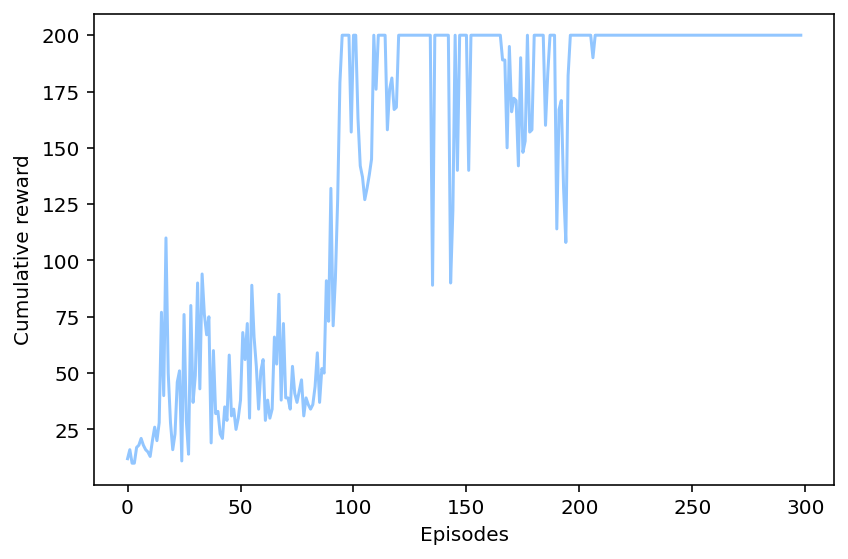

In [ ]:
plt.plot(reward_history[0:e], label='Reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.tight_layout()
plt.show()

Empirical observations:

*   it is well known that policy gradient algorithms are noisy, and indeed we can observe it very clearly in the 
*   increasing the learning rate accelerates learning (e.g. going from 0.001 to 0.01 more than halves the number of epochs required to reach the maximum score)
*   we can modify $J_t$ by subtracting a “baseline” so as to reduce the variance of the results; one very important baseline is such that $J_t$ becomes the so-called advantage, which forms the basis for actor-critic algorithms




## Trying it

In [ ]:
env = wrap_env(gym.make("CartPole-v0"))
s = env.reset()
s = np.reshape(s, [1, dim_state_space])

done = False
cum_reward = 0

while not done:

  env.render()
  a = agent.policy(s)
  s_, r, done, _ = env.step(a)
  s_ = np.reshape(s_, [1, dim_state_space])
  agent.remember(s, a, r, s_, done)
  cum_reward += r
  s = s_

env.close()

print('We got a reward equal to {:.0f}'.format(cum_reward))

We got a reward equal to 200


In [ ]:
show_video()